# Problem - 1

Train a DC GAN (with an architecture of your choice) on the given data
with the usual GAN loss. Plot the loss curves for the Generator and
Discriminator losses.

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torchvision.utils as vutils
%matplotlib inline
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)



In [2]:
data_dir = "Animals_data"  

ngpu = 1 #number of gpu available
img_size = 128

batch_size = 128

z=100 #latent space size

workers = 4 #number of workers for dataloader

gf = 64 #generator filter size
df = 64 #discriminator filter size

lr = 0.0002 #learning rate
beta1 = 0.5 #beta1 for adam
epochs = 5 #number of epochs to train for



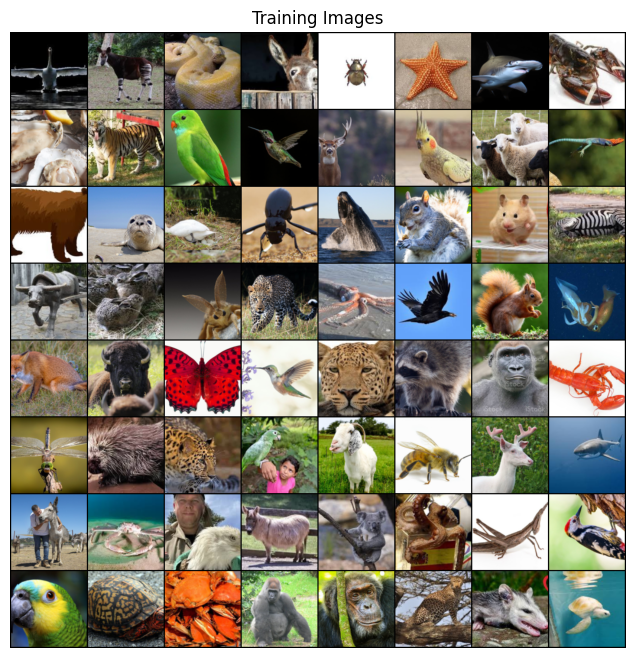

In [3]:

dataset  =  datasets.ImageFolder(root=data_dir, transform=transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

### Weights Initialization (According to DCGAN paper)

In [4]:
# weights initialization for the generator and discriminator
# In DC-GAN, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. Using the same 
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        
        

## Generator Model

In [5]:
# Generator
class Generator(nn.Module):
    def __init__(self): 
        super(Generator, self).__init__()  
        self.gen = nn.Sequential(
            nn.ConvTranspose2d(in_channels=z, out_channels=gf*16, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(gf*16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*16, out_channels=gf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf*8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*8, out_channels=gf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf*4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*4, out_channels=gf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf*2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf*2, out_channels=gf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(gf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=gf, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
            
        )
    def forward(self, input):
        return self.gen(input)
    
print(Generator())
            

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNo

In [6]:
Gen_model = Generator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    Gen_model = nn.DataParallel(Gen_model, device_ids=[0, 1])
    
Gen_model.apply(weights_init) # apply the weights_init function


Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNo

## Discriminator Model 

In [7]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=df, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df, out_channels=df*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*2, out_channels=df*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*4, out_channels=df*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*8, out_channels=df*16, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(df*16),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=df*16, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            
        )
    def forward(self, input, noise_variance):
        
        input = input + noise_variance*torch.randn_like(input)
        return self.disc(input)
    
print(Discriminator())

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [8]:
Disc_model = Discriminator().to(device)

if (device.type == 'cuda') and (ngpu > 1):
    Disc_model = nn.DataParallel(Disc_model, device_ids=[0, 1])
    
Disc_model.apply(weights_init) # apply the weights_init function


Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [9]:
criterion = nn.BCELoss()

fixed_noise = torch.randn(64, z, 1, 1, device=device)

real_label = 1
fake_label = 0

optimizerD = optim.Adam(Disc_model.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(Gen_model.parameters(), lr=lr, betas=(beta1, 0.999))



## Training

In [10]:
img_list = []
gen_losses = [] 
disc_losses = []
label_smoothing = False
noise_variance = 0.2
gen_updates = 1
disc_updates = 1

In [11]:
iters = 0
num_epochs = 100
print("Starting Training Loop...")

for epoch in range(num_epochs):
    
    for i,data in enumerate(dataloader, 0):
       
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        
        
            
        # update Disc model : maximize log(D(x)) + log(1 - D(G(z)))
        Disc_model.zero_grad()
        label = torch.full((b_size,), real_label, device=device, dtype=torch.float)
        output = Disc_model(real_cpu, noise_variance).view(-1)
        
        
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        noise = torch.randn(b_size, z, 1, 1, device=device)
        fake = Gen_model(noise)
        label.fill_(fake_label)
        output = Disc_model(fake.detach(), noise_variance).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        disc_losses.append(errD.item())
        
    
            
        # update Gen model : maximize log(D(G(z)))
        Gen_model.zero_grad()
        label.fill_(real_label)
        output = Disc_model(fake, noise_variance).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        gen_losses.append(errG.item())
            
    
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        if (iters)%500 == 0 or (i == len(dataloader)-1) or (epoch == num_epochs-1):
            with torch.no_grad():
                fake = Gen_model(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            plt.imsave(f"new_images/{epoch}_{iters}.png", img_list[-1].numpy().transpose((1,2,0)))
            
        iters += 1
        
    if epoch%10 == 0:
        torch.save(Gen_model.state_dict(), "models/Gen_model.pth")
        torch.save(Disc_model.state_dict(), "models/Disc_model.pth")
        
       
            
            

Starting Training Loop...
[0/100][0/43]	Loss_D: 0.5900	Loss_G: 2.6716	D(x): 0.9580	D(G(z)): 0.2360 / 0.1106
[0/100][10/43]	Loss_D: 1.3636	Loss_G: 1.0240	D(x): 0.4252	D(G(z)): 0.2237 / 0.4013
[0/100][20/43]	Loss_D: 0.5502	Loss_G: 1.6867	D(x): 0.7465	D(G(z)): 0.1515 / 0.3215
[0/100][30/43]	Loss_D: 0.8859	Loss_G: 4.5353	D(x): 0.8702	D(G(z)): 0.4136 / 0.0201
[0/100][40/43]	Loss_D: 0.3015	Loss_G: 4.2721	D(x): 0.8392	D(G(z)): 0.0884 / 0.0256
[1/100][0/43]	Loss_D: 0.4958	Loss_G: 4.7380	D(x): 0.7436	D(G(z)): 0.0758 / 0.0188
[1/100][10/43]	Loss_D: 0.2880	Loss_G: 5.0193	D(x): 0.9199	D(G(z)): 0.1449 / 0.0207
[1/100][20/43]	Loss_D: 0.3798	Loss_G: 6.4478	D(x): 0.8838	D(G(z)): 0.2083 / 0.0036
[1/100][30/43]	Loss_D: 1.1287	Loss_G: 4.2508	D(x): 0.4862	D(G(z)): 0.0115 / 0.0547
[1/100][40/43]	Loss_D: 1.4826	Loss_G: 6.3766	D(x): 0.7377	D(G(z)): 0.4000 / 0.0055
[2/100][0/43]	Loss_D: 1.0359	Loss_G: 7.3571	D(x): 0.9274	D(G(z)): 0.5071 / 0.0016
[2/100][10/43]	Loss_D: 0.2621	Loss_G: 3.4342	D(x): 0.9147	D(G(z)